# Study of Crypto and Non Crypto currencies (Penn Gaming Exam)

In [138]:
import datetime        # For calculating dates and time
import requests        # For getting the data from REST API
import psycopg2        # For connecting to the postgres DB
import pandas as pd    # pandas for building dataframe
from IPython.display import Image    # For insertion of snapshot
import matplotlib.pyplot as plt      # For visualizaton
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Postgres db connection details
hostname = 'localhost'
username = 'postgres'
password = 'Penngaming@123'
database = 'postgres'

In [37]:
# Table creation in postgres db
# As per the documentation on coinAPI the fields returned in historical data are taken as the columns of the table.
# We have added ID as primary key and asset_id(BTC etc.) as well to know as to which cryptocurrency the records belongs to.

def tableGeneration( conn ) :
    cur = conn.cursor()

    cur.execute( "CREATE TABLE public.CRYPTOCURRENCY(\
   ID SERIAL PRIMARY KEY NOT NULL,\
   asset_id CHAR(100),\
   time_period_start TIMESTAMP with time zone,\
   time_period_end TIMESTAMP with time zone,\
   time_open TIMESTAMP with time zone,\
   time_close TIMESTAMP with time zone,\
   price_open REAL,\
   price_high REAL,\
   price_low REAL,\
   price_close REAL,\
   volume_traded REAL,\
   trades_count REAL)" )
    
    cur.close()
    conn.commit()

myConnection = psycopg2.connect( host=hostname, user=username, password=password, dbname=database )
tableGeneration( myConnection )
myConnection.close()


### Database table created in the postgres db
Below is the snapshot of the table Cryptocurrency in the public schema

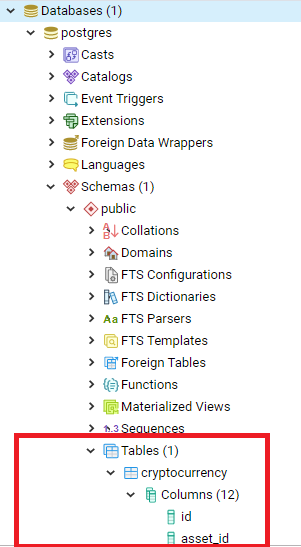

In [40]:
Image(filename='pgAdmin_4_table.png')

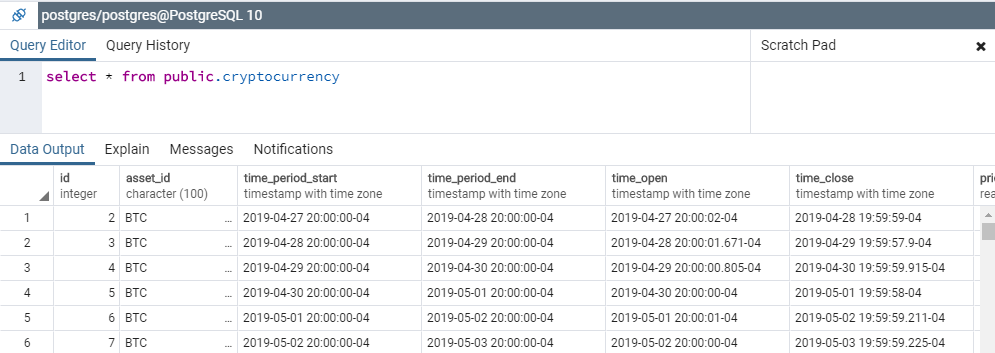

In [13]:
Image(filename='pgAdmin_4_records.png')

In [41]:
# Preparatory function for data insertion in postgres db

def doQuery( conn, query ) :
    cur = conn.cursor()

    cur.execute( query )
    
    cur.close()
    conn.commit()

### Data pulling strategy
- This block takes crypto asset_ids for which the data needs to be pulled until the user says STOP.
- We have used the period_id as 1DAY which gives one row for each day containing information of all the columns of the table public.CRYPTOCURRENCY  table.
- We have invoked the historical data API 4 times for each currency (cryto or non crypto) providing OHLCV (Open, High, Low, Close, Volume) timeseries data.
- Since only 100 datapoints were provided for a single API call, so to cover one year (365 data points) the API was 4 times for each currency.
- We have used the asset_id_quote as USD for all four cryptocurrencies being asset_id_base (BTC, ETH, XRP, DOGE)
- For a non cryptocurrency we have pulled data for USD (asset_id_base) with BTC being asset_id_quote.

In [43]:

crypto = 'START'
primary_key = 1
while crypto != 'STOP':
    crypto = input("Please enter the asset_id_base of the cryptocurrency like BTC, ETH etc. or STOP to end data collection  : ")
    if crypto == 'STOP':
        break
    asset_id_quote = input("Please enter the asset_id_quote: ")
    # Pull data for the entered cryptocurrency for one year
    print("pulling data for ", crypto)
    for i in range(0,4):
        time_end = datetime.datetime.today() - datetime.timedelta(days=i*100)
        time_start = time_end - datetime.timedelta(days=100)
        time_end = str(time_end).split('.')[0]
        time_end = time_end.split()
        time_end = 'T'.join(time_end)
        time_start = str(time_start).split('.')[0]
        time_start = time_start.split()
        time_start = 'T'.join(time_start)        
        url = 'https://rest.coinapi.io/v1/ohlcv/'+crypto+'/'+asset_id_quote+'/'+'history?period_id=1DAY&time_start='+time_start+'&time_end='+time_end+'&include_empty_items=false&output_format=csv'
        #url = 'https://rest.coinapi.io/v1/ohlcv/BTC/USD/history?period_id=1MIN&time_start=2016-01-01T00:00:00'
        headers = {'X-CoinAPI-Key' : 'CF5A6DF8-43BE-4774-8ABF-747FA077C76A'}
        response = requests.get(url, headers=headers)
        
        # Checking if the response is ok and we received the data from API call
        if response.status_code == 200 and response.text:
            print("data pulled successfully")
    
        # Insertion of data in postgres db
        print("inserting the data for ", crypto, " to the postgres db")
        data = response.text
        # Adding a primary key and asset_id to the pulled data
        insertion_data = []
        data = data.split('\n')
        for line in data:
            if line == '':
                continue
            line = str(primary_key)+';'+crypto+';'+line
            insertion_data.append(line)
            primary_key += 1
        
        # Writing the data to a text file so that the data can be easily imported to our public.CRYPTOCURRENCY table
        insertion_data = '\n'.join(insertion_data)
        f = open('C:/Users/Public/crypto_file.txt', "w")
        f.write(insertion_data)
        f.close()
        query = "COPY public.CRYPTOCURRENCY FROM 'C:/Users/Public/crypto_file.txt' WITH DELIMITER ';' CSV HEADER"
        
        # Invoking database connection to write the data
        myConnection = psycopg2.connect( host=hostname, user=username, password=password, dbname=database )
        doQuery( myConnection, query )
        myConnection.close()
    

Please enter the asset_id_base of the cryptocurrency like BTC, ETH etc. or STOP to end data collection  : BTC
Please enter the asset_id_quote: USD
pulling data for  BTC
data pulled successfully
inserting the data for  BTC  to the postgres db
data pulled successfully
inserting the data for  BTC  to the postgres db
data pulled successfully
inserting the data for  BTC  to the postgres db
data pulled successfully
inserting the data for  BTC  to the postgres db
Please enter the asset_id_base of the cryptocurrency like BTC, ETH etc. or STOP to end data collection  : ETH
Please enter the asset_id_quote: USD
pulling data for  ETH
data pulled successfully
inserting the data for  ETH  to the postgres db
data pulled successfully
inserting the data for  ETH  to the postgres db
data pulled successfully
inserting the data for  ETH  to the postgres db
data pulled successfully
inserting the data for  ETH  to the postgres db
Please enter the asset_id_base of the cryptocurrency like BTC, ETH etc. or STO

### Limitation to pull data from Coin API
- A single API call can pull out a maximum of 100 datapoints in a day.
- A user without any premium subscription is allowed to make a maximum of 100 API calls per day.
- Hence the upper limit of the data points in our dataset is 10000 (which is not huge), it is almost always beneficial to have more datapoints.

### Database generated
- The database consists of five currencies, four crypto currencies ans one non crypto currency (US Dollar).
- Let us pull the data into a pandas dataframe which will help us analyze the dataset and vizuale interesting patterns.
- Since the number of rows we have in our database is ~ 400*5 = 2000, so we can pull all the rows in the dataframe

In [7]:
# Fetching data from the postgres DB
try:
   connection = psycopg2.connect(user=username,
                                  password=password,
                                  host=hostname,
                                  database=database)
   cursor = connection.cursor()
   postgreSQL_select_Query = "select * from public.cryptocurrency"
   cursor.execute(postgreSQL_select_Query)
   print("Selecting rows from cryptocurrency table using cursor.fetchall")
   cryptocurrency_records = cursor.fetchall() 
   
except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)
finally:
    #closing database connection.
    if(connection):
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")
        
print('Number of records fetched: ',len(cryptocurrency_records))

Selecting rows from cryptocurrency table using cursor.fetchall
PostgreSQL connection is closed
Number of records fetched:  2000


In [123]:
# Putting the data to pandas dataframe

df = pd.DataFrame(cryptocurrency_records, columns=['ID','asset_id','time_period_start','time_period_end','time_open','time_close','price_open','price_high','price_low','price_close','volume_traded','trades_count'])


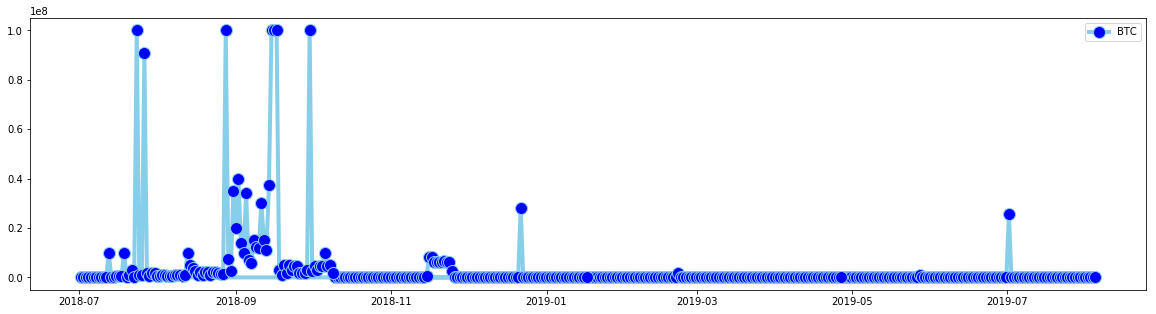

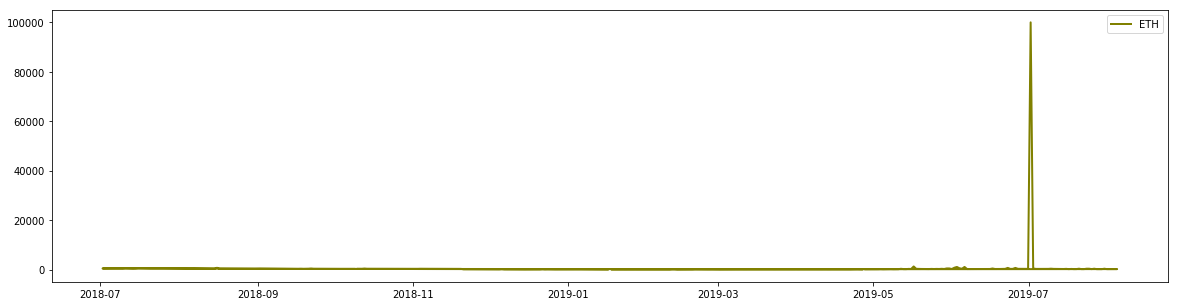

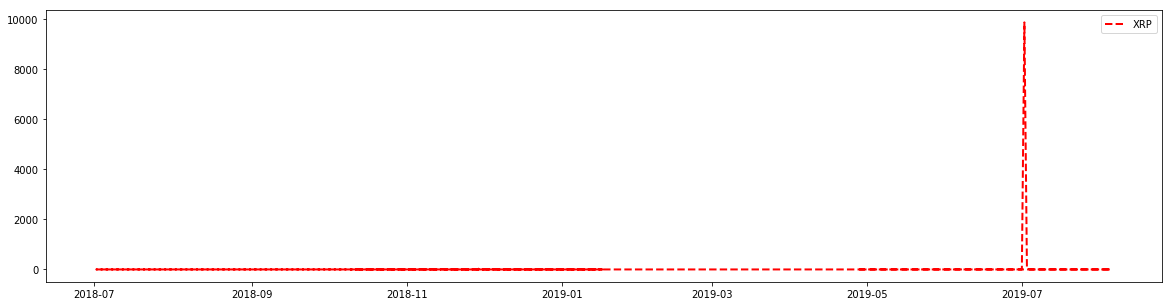

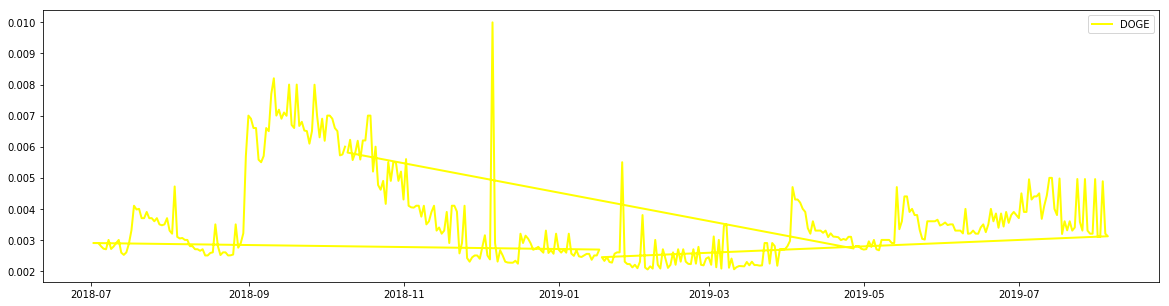

In [75]:
# Let us see the trend of all the currencies:

# Price_High trend for all crypto currencies
# Cleaning first
df['asset_id'] = df['asset_id'].map(lambda x: x.rstrip(' .'))
BTC = df.loc[df['asset_id'] == 'BTC']
ETH = df.loc[df['asset_id'] == 'ETH']
XRP = df.loc[df['asset_id'] == 'XRP']
DOGE = df.loc[df['asset_id'] == 'DOGE']
df2=pd.DataFrame({'x': df['time_period_start'], 'y1': BTC['price_high']})
df3=pd.DataFrame({'x': df['time_period_start'], 'y2': ETH['price_high']})
df4=pd.DataFrame({'x': df['time_period_start'], 'y3': XRP['price_high']})
df5=pd.DataFrame({'x': df['time_period_start'], 'y4': DOGE['price_high']})

# multiple line plot
plt.figure(figsize=(20,5))
plt.plot( 'x', 'y1', data=df2, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="BTC")
plt.legend()
plt.figure(figsize=(20,5))
plt.plot( 'x', 'y2', data=df3, marker='', color='olive', linewidth=2, label="ETH")
plt.legend()
plt.figure(figsize=(20,5))
plt.plot( 'x', 'y3', data=df4, marker='', color='red', linewidth=2, linestyle='dashed', label="XRP")
plt.legend()
plt.figure(figsize=(20,5))
plt.plot( 'x', 'y4', data=df5, marker='', color='yellow', linewidth=2, label="DOGE")
plt.legend()

### Interpretation of above graphs
- It can be seen that the fluctuations high price of for ETH and XRP is very similar although the values for ETH are much higher as compared to XRP
- It can also be noted that for DOGE range of high price is lowest but the high price of DOGE peaked for good length of time in past one year and then there can be seen an overall downward trend.
- BTC range for high price is highest. The fluctuation graph shows that high price peaked frequently before 11th month of 2018 and then remains almost steady

### Investigate which coin perfromed better
- In order to check which coin performed better we need to see the price_open and price_close and which coin had a positive delta at the end.
- We can see the everyday performance by calculating overall delta between price_open and price_close in last one year for each coin.

In [63]:
BTC_deltas = BTC['price_close'] - BTC['price_open']
ETH_deltas = ETH['price_close'] - ETH['price_open']
XRP_deltas = XRP['price_close'] - XRP['price_open']
DOGE_deltas = DOGE['price_close'] - DOGE['price_open']

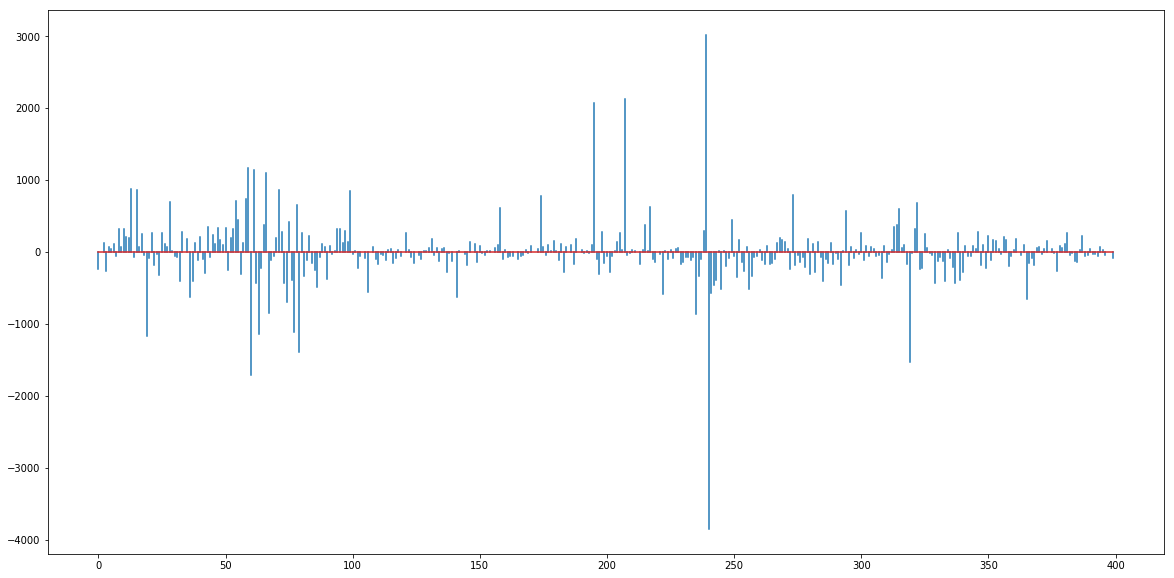

For BTC in one year there had been an increase of -3137.470000000014


In [64]:
plt.figure(figsize=(20,10))
plt.stem(BTC_deltas, markerfmt=' ', bottom=0)
plt.show()

# Calculating BTC cummulative delta for one year i.e. summation of (price_close - price_open) for one year.
delta_sum_BTC = 0
for delta in BTC_deltas:
    delta_sum_BTC = delta_sum_BTC + delta

print("For BTC in one year there had been an increase of", delta_sum_BTC)

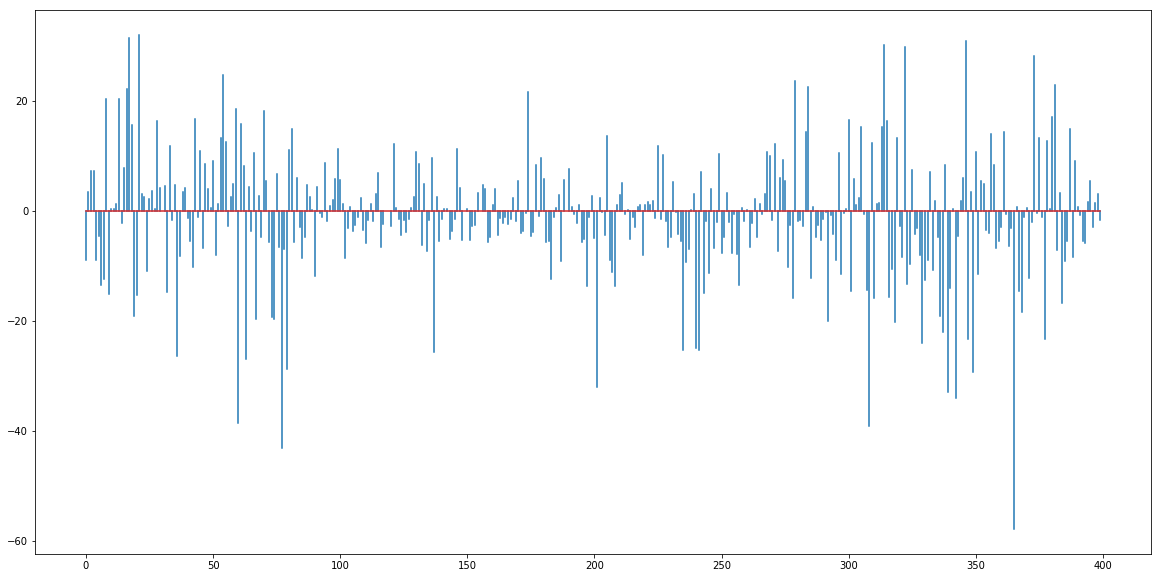

For ETH in one year there had been an increase of -464.7139999999997


In [65]:
plt.figure(figsize=(20,10))
plt.stem(ETH_deltas, markerfmt=' ', bottom=0)
plt.show()

# Calculating ETH cummulative delta for one year i.e. summation of (price_close - price_open) for one year.
delta_sum_ETH = 0
for delta in ETH_deltas:
    delta_sum_ETH = delta_sum_ETH + delta

print("For ETH in one year there had been an increase of", delta_sum_ETH)

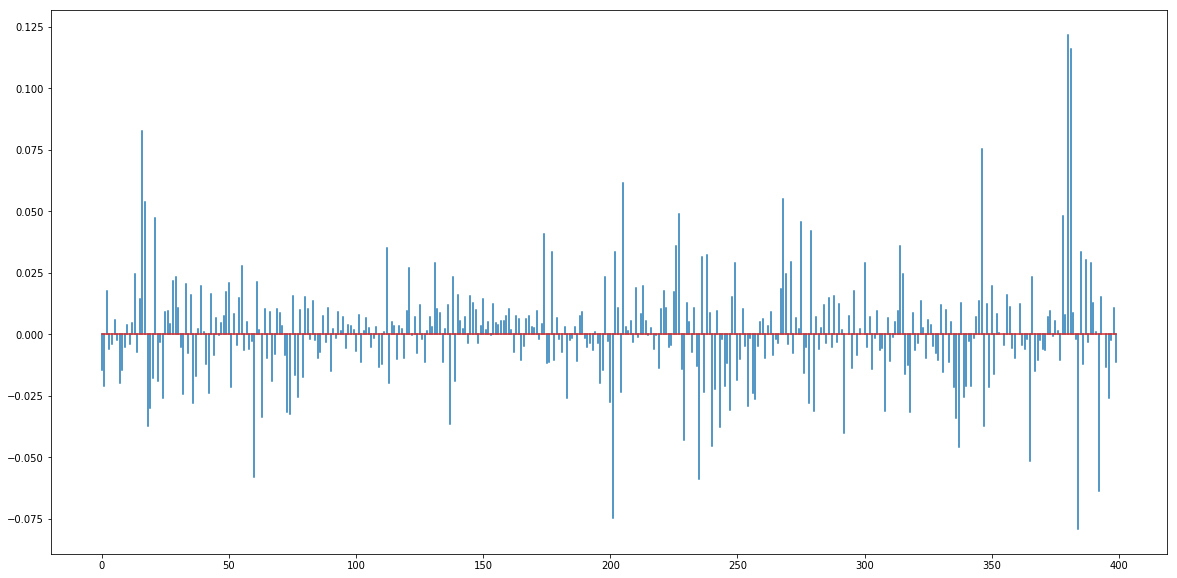

For XRP in one year there had been an increase of 0.23544400000000032


In [66]:
plt.figure(figsize=(20,10))
plt.stem(XRP_deltas, markerfmt=' ', bottom=0)
plt.show()

# Calculating XRP cummulative delta for one year i.e. summation of (price_close - price_open) for one year.
delta_sum_XRP = 0
for delta in XRP_deltas:
    delta_sum_XRP = delta_sum_XRP + delta

print("For XRP in one year there had been an increase of", delta_sum_XRP)

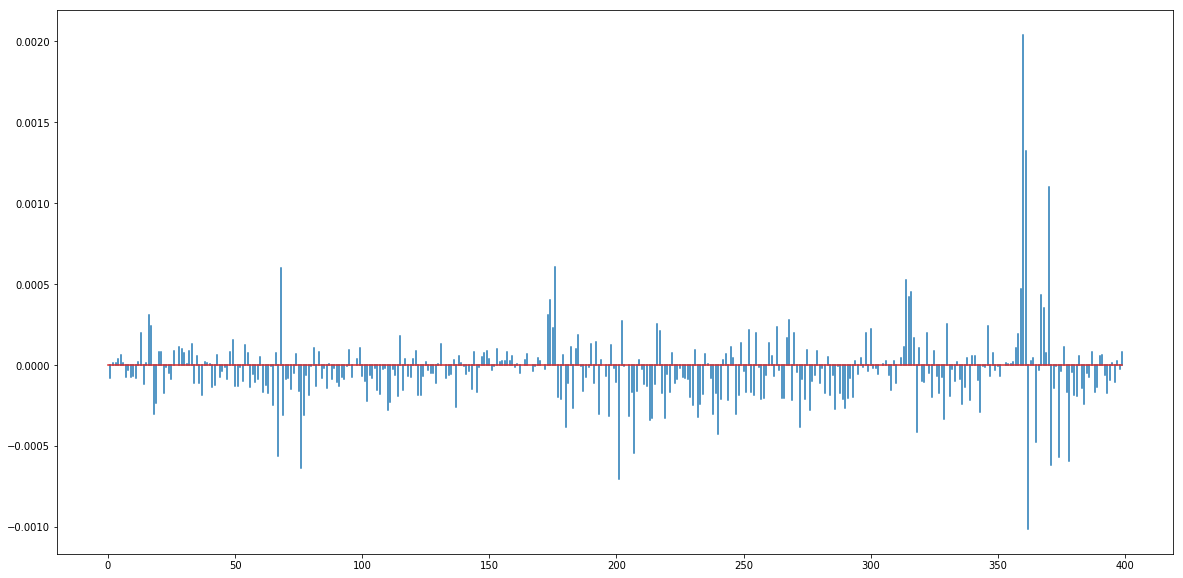

For DOGE in one year there had been an increase of -0.01368832000000001


In [67]:
plt.figure(figsize=(20,10))
plt.stem(DOGE_deltas, markerfmt=' ', bottom=0)
plt.show()

# Calculating DOGE cummulative delta for one year i.e. summation of (price_close - price_open) for one year.
delta_sum_DOGE = 0
for delta in DOGE_deltas:
    delta_sum_DOGE = delta_sum_DOGE + delta

print("For DOGE in one year there had been an increase of", delta_sum_DOGE)

## Hence the performance of these coins in last one year is as follows:
- It can be seen that XRP has an overall increase of 0.23544 which has performed the best.
- It can also be noted that BTC has perfromed worst with a highest decrease of -3137.47

In [73]:
cummulative_performance = [delta_sum_BTC, delta_sum_ETH,delta_sum_XRP,delta_sum_DOGE]
print(' BTC: ', cummulative_performance[0],'\n', 'ETH: ', cummulative_performance[1], '\n', 'XRP: ', cummulative_performance[2], '\n', 'DODGE: ', cummulative_performance[3])

 BTC:  -3137.470000000014 
 ETH:  -464.7139999999997 
 XRP:  0.23544400000000032 
 DODGE:  -0.01368832000000001


## Comparison of cryptocurrency with USD
- Let us compare the performance of USD as compared to the cryptocurrencies

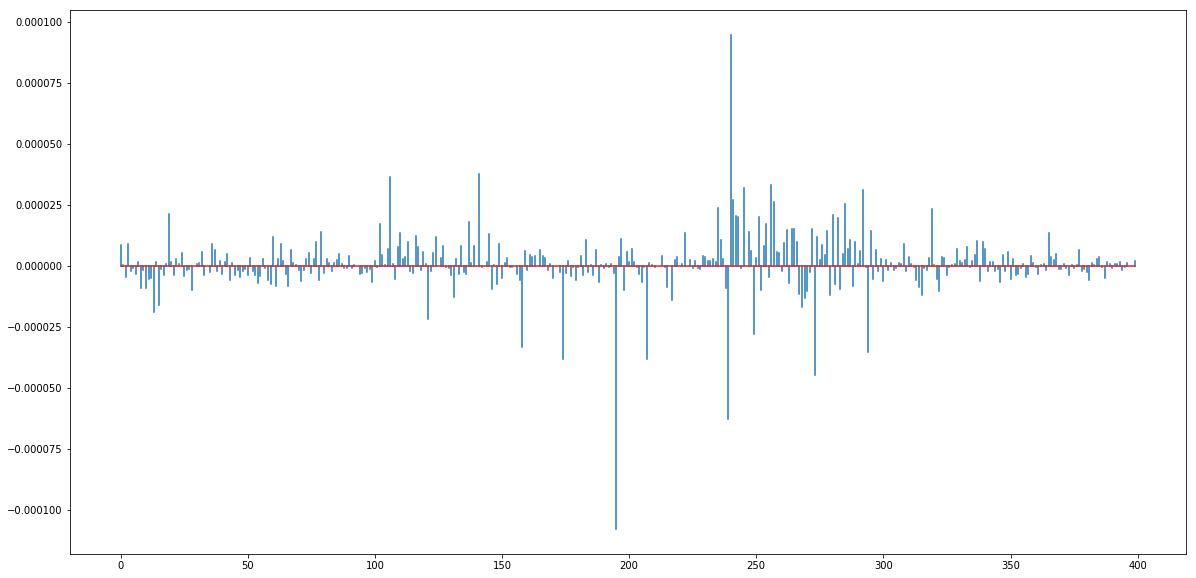

For USD in one year there had been an increase of 0.00030937269999999984


In [77]:
USD = df.loc[df['asset_id'] == 'USD']
USD_deltas = USD['price_close'] - USD['price_open']

plt.figure(figsize=(20,10))
plt.stem(USD_deltas, markerfmt=' ', bottom=0)
plt.show()

# Calculating USD cummulative delta for one year i.e. summation of (price_close - price_open) for one year.
delta_sum_USD = 0
for delta in USD_deltas:
    delta_sum_USD = delta_sum_USD + delta

print("For USD in one year there had been an increase of", delta_sum_USD)

Hence it can be seen that USD has performed better than BTC, ETH and DOGE but has not performed better than XRP

# Possible future work
- It can be interesting to do a time series different coins and fir the model
- With the help of the model future attributes of a coin can be predicted like price-high, price_low etc.